In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from scipy.stats import binned_statistic

%matplotlib inline

# Load Data

In [2]:
# df = pd.read_csv('../data/airborne_data.csv', parse_dates=['timestamp'], index_col='timestamp')
# df = pd.read_csv('../data/airborne_data_20241015.csv', parse_dates=['timestamp'], index_col='timestamp')
# merged_df = pd.read_csv("/home/jpalmo/fs09/Projects/O3Fire/model_eval/output/model_obs_2024.7.31.csv")
merged_df = pd.read_csv("/home/jpalmo/fs09/Projects/O3Fire/model_eval/output/model_obs_2025.4.16.csv")

/tmp/ipykernel_2895066/1655833888.py:4: DtypeWarning: Columns (240,242) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv("/home/jpalmo/fs09/Projects/O3Fire/model_eval/output/model_obs_2025.4.16.csv")


In [3]:
merged_df['NOx_model'] = merged_df['NO_model'] + merged_df['NO2_model']
merged_df['NOx_nested_model'] = merged_df['NO_nested_model'] + merged_df['NO2_nested_model']

# Analysis

In [4]:
def binned_scatterplot(x, y, bins, ydy=None, show_raw=False, label=None, how='scipy', ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
        
    df = pd.DataFrame({'x':x,
                        'y':y,})
                        # 'ydy':ydy})
    
    df[~np.isfinite(df)] = np.nan
    df = df.dropna()
    
    if how == 'qcut':
        df['bins'] = pd.qcut(df['x'], bins)
        df["bin_centers"] = df["bins"].apply(lambda x: x.mid).astype('float64')
        for i,g in df.groupby('bins'):
            p = ax.errorbar(g['bin_centers'].mean(), g['y'].mean(), yerr= g['y'].std(), **kwargs)
    elif how == 'scipy':
        bin_result = binned_statistic(df['x'].values, df['y'].values, statistic='mean', bins=bins,)
        bin_edges = (bin_result.bin_edges)
        bin_result_std = binned_statistic(df['x'].values, df['y'].values, statistic='std', bins=bins,)
        bin_centers = bin_result.bin_edges[1:] - (abs(bin_result.bin_edges[0]-bin_result.bin_edges[1]))/2
        p = ax.errorbar(bin_centers, bin_result.statistic, yerr= bin_result_std.statistic, **kwargs)
    elif how == 'ols':
        ranges = bins[0:-1]+(abs(bins[1] - bins[0]))/2
        df['xcol'] = pd.cut(df['x'], bins)
        binned_scatter_dict = {}
        means = []
        stds = []
        Ns = []
        for j,b in df.groupby('xcol'):
            try:
                slope, r2, se = lin_fit(b, 'ydy', 'y')
                means.append(slope)
                stds.append(r2)
                Ns.append(len(b.dropna()))
            except:
                means.append(np.nan)
                stds.append(np.nan)
                Ns.append(np.nan)
        binned_scatter_dict['mean'] = means
        binned_scatter_dict['std'] = stds
        binned_scatter_dict['N'] = Ns
        p = ax.errorbar(ranges, binned_scatter_dict['mean'], yerr=binned_scatter_dict['std'], **kwargs)
    else:
        return
    
    if show_raw:
        ax.scatter(df['x'], df['y'], alpha=0.05, **kwargs)
    if label:
        p.set_label(label)
        
    return ax#, bin_edges

# Plot

In [5]:
# Define the minimum and maximum values (equivalent to 10^0 and 10^2.3 for log scaling)
min_value = 0.
max_value = 200

# Define the number of bins
num_bins = 9

# Generate bins that are spaced according to the square root
sqrt_bins = np.linspace(np.sqrt(min_value), np.sqrt(max_value), num_bins)**2


### Figure 8

In [6]:
merged_df['O3/CO_model'] = merged_df['O3_delta_campaignsplit_model']/merged_df['CO_delta_campaignsplit_model']
merged_df['O3/CO_nested_model'] = merged_df['O3_nested_delta_campaignsplit_model']/merged_df['CO_nested_delta_campaignsplit_model']

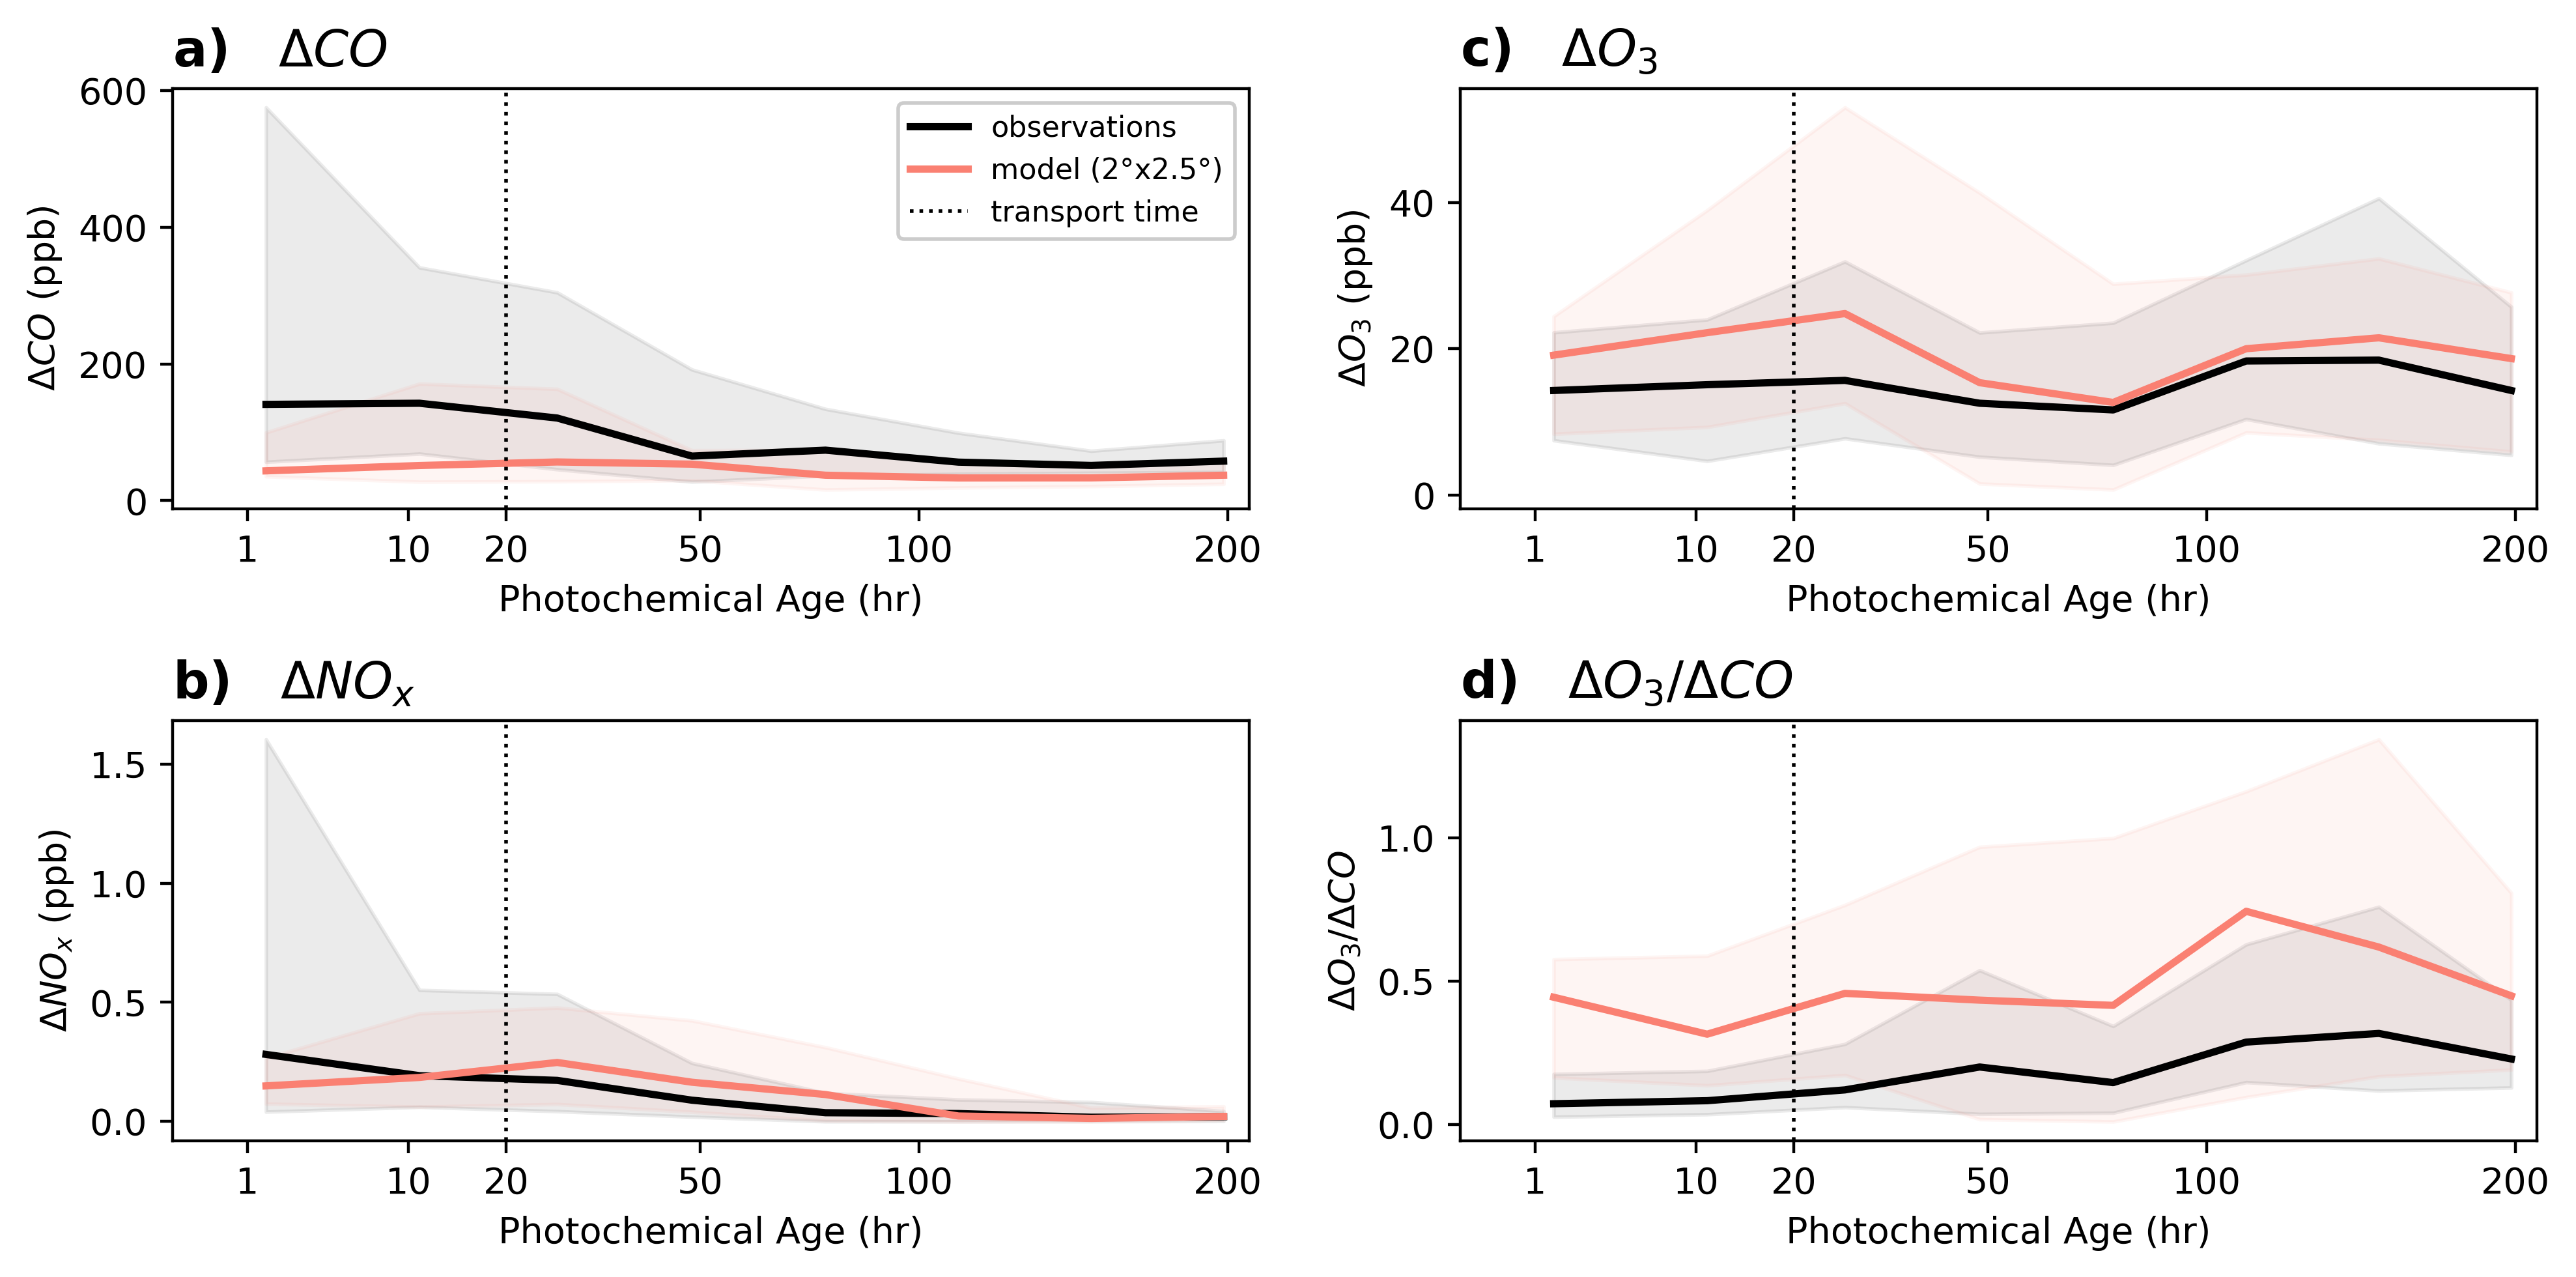

In [13]:
# Create figure with 4 panels
fig, axs = plt.subplots(2, 2, figsize=(10,5), dpi=400)

# Flatten axs for easier iteration
axs = axs.flatten()

# Define the variables to plot
variables = [
    {'col': 'CO_delta', 'model_col': 'CO_delta_campaignsplit_model', 'title': '   $\Delta CO$', 'ylabel': '$\Delta CO$ (ppb)', 'letter': r'$\bf{a) }$'},
    {'col': 'O3_delta', 'model_col': 'O3_delta_campaignsplit_model', 'title': '   $\Delta O_3$', 'ylabel': '$\Delta O_3$ (ppb)', 'letter': r'$\bf{c) }$'},
    {'col': 'NOx_delta', 'model_col': 'NOx_delta_campaignsplit_model', 'title': '   $\Delta NO_x$', 'ylabel': '$\Delta NO_x$ (ppb)', 'letter': r'$\bf{b) }$'},
    {'col': 'O3/CO', 'model_col': 'O3/CO_model', 'title': '   $\Delta O_3 / \Delta CO$', 'ylabel': '$\Delta O_3 / \Delta CO$', 'letter': r'$\bf{d) }$'},
]

for idx, var in enumerate(variables):
    col = var['col']
    model_col = var['model_col']
    
    model_colors = {model_col: 'salmon', col:'k',}
    
    tmp = merged_df.copy(deep=True)
    if col != 'O3/CO':  # Don't scale O3/CO ratio
        tmp[model_col] = tmp[model_col]*1e9
        # tmp[nested_model_col] = tmp[nested_model_col]*1e9
        tmp[col] = tmp[col]*1e-3
    
    # observations
    bin_result = binned_statistic(tmp['age'].values, tmp[col].values, statistic=lambda y:np.nanmedian(y), bins=sqrt_bins)
    tenth_result = binned_statistic(tmp['age'].values, tmp[col].values, statistic=lambda y:np.nanpercentile(y,16), bins=sqrt_bins)
    ninetieth_result = binned_statistic(tmp['age'].values, tmp[col].values, statistic=lambda y:np.nanpercentile(y,84), bins=sqrt_bins)
    bin_centers = bin_result.bin_edges[1:] - (abs(bin_result.bin_edges[0]-bin_result.bin_edges[1]))/2
    
    axs[idx].plot(bin_centers, bin_result.statistic, label='observations', color=model_colors[col], linewidth=2)
    axs[idx].fill_between(bin_centers, tenth_result.statistic, ninetieth_result.statistic, alpha=0.08, color=model_colors[col])
    
    # model
    bin_result = binned_statistic(tmp['age'].values, tmp[model_col].values, statistic=lambda y:np.median(y), bins=sqrt_bins)
    tenth_result = binned_statistic(tmp['age'].values, tmp[model_col].values, statistic=lambda y:np.nanpercentile(y,16), bins=sqrt_bins)
    ninetieth_result = binned_statistic(tmp['age'].values, tmp[model_col].values, statistic=lambda y:np.nanpercentile(y,84), bins=sqrt_bins)
    
    axs[idx].plot(bin_centers, bin_result.statistic, label='model (2°x2.5°)', color=model_colors[model_col], linewidth=2)
    axs[idx].fill_between(bin_centers, tenth_result.statistic, ninetieth_result.statistic, alpha=0.08, color=model_colors[model_col])
    
    axs[idx].axvline(x=20, label="transport time", color='black', linestyle=':', linewidth=1)
    
    # Set scales and labels
    axs[idx].set_xscale('function', functions=(np.sqrt, np.square))
    axs[idx].set_title(var['letter']+var['title'], loc='left', fontsize=14)
    axs[idx].set_ylabel(var['ylabel'], fontsize=10)
    axs[idx].set_xlabel('Photochemical Age (hr)', fontsize=10)
    
    axs[idx].set_xticks([1, 10, 20, 50, 100, 200])
    axs[idx].set_xticklabels([1, 10, 20, 50, 100, 200])
    axs[idx].set_xlim(left=0)
    
    if idx == 0:  # Only show legend for first panel
        axs[idx].legend(fontsize=8, framealpha=1)

# Adjust layout to prevent overlapping
plt.tight_layout()

#save figure as pdf
plt.savefig("../../figures/fig_08.pdf", bbox_inches='tight', dpi=300)

### Figure S13

In [16]:
# NO/NO2
merged_df['NO/NO2'] = merged_df['NO']/merged_df['NO2']
merged_df['NO/NO2_model'] = merged_df['NO_model']/merged_df['NO2_model']

# HNO3/H2O2
merged_df['HNO3/H2O2'] = merged_df['HNO3']/merged_df['H2O2']
merged_df['HNO3/H2O2_model'] = merged_df['HNO3_model']/merged_df['H2O2_model']

# CH2O/NO2

merged_df['CH2O/NO2'] = merged_df['CH2O']/merged_df['NO2']
merged_df['CH2O/NO2_model'] = merged_df['CH2O_model']/merged_df['NO2_model']

/home/jpalmo/.conda/envs/o3fire/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/jpalmo/.conda/envs/o3fire/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/home/jpalmo/.conda/envs/o3fire/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


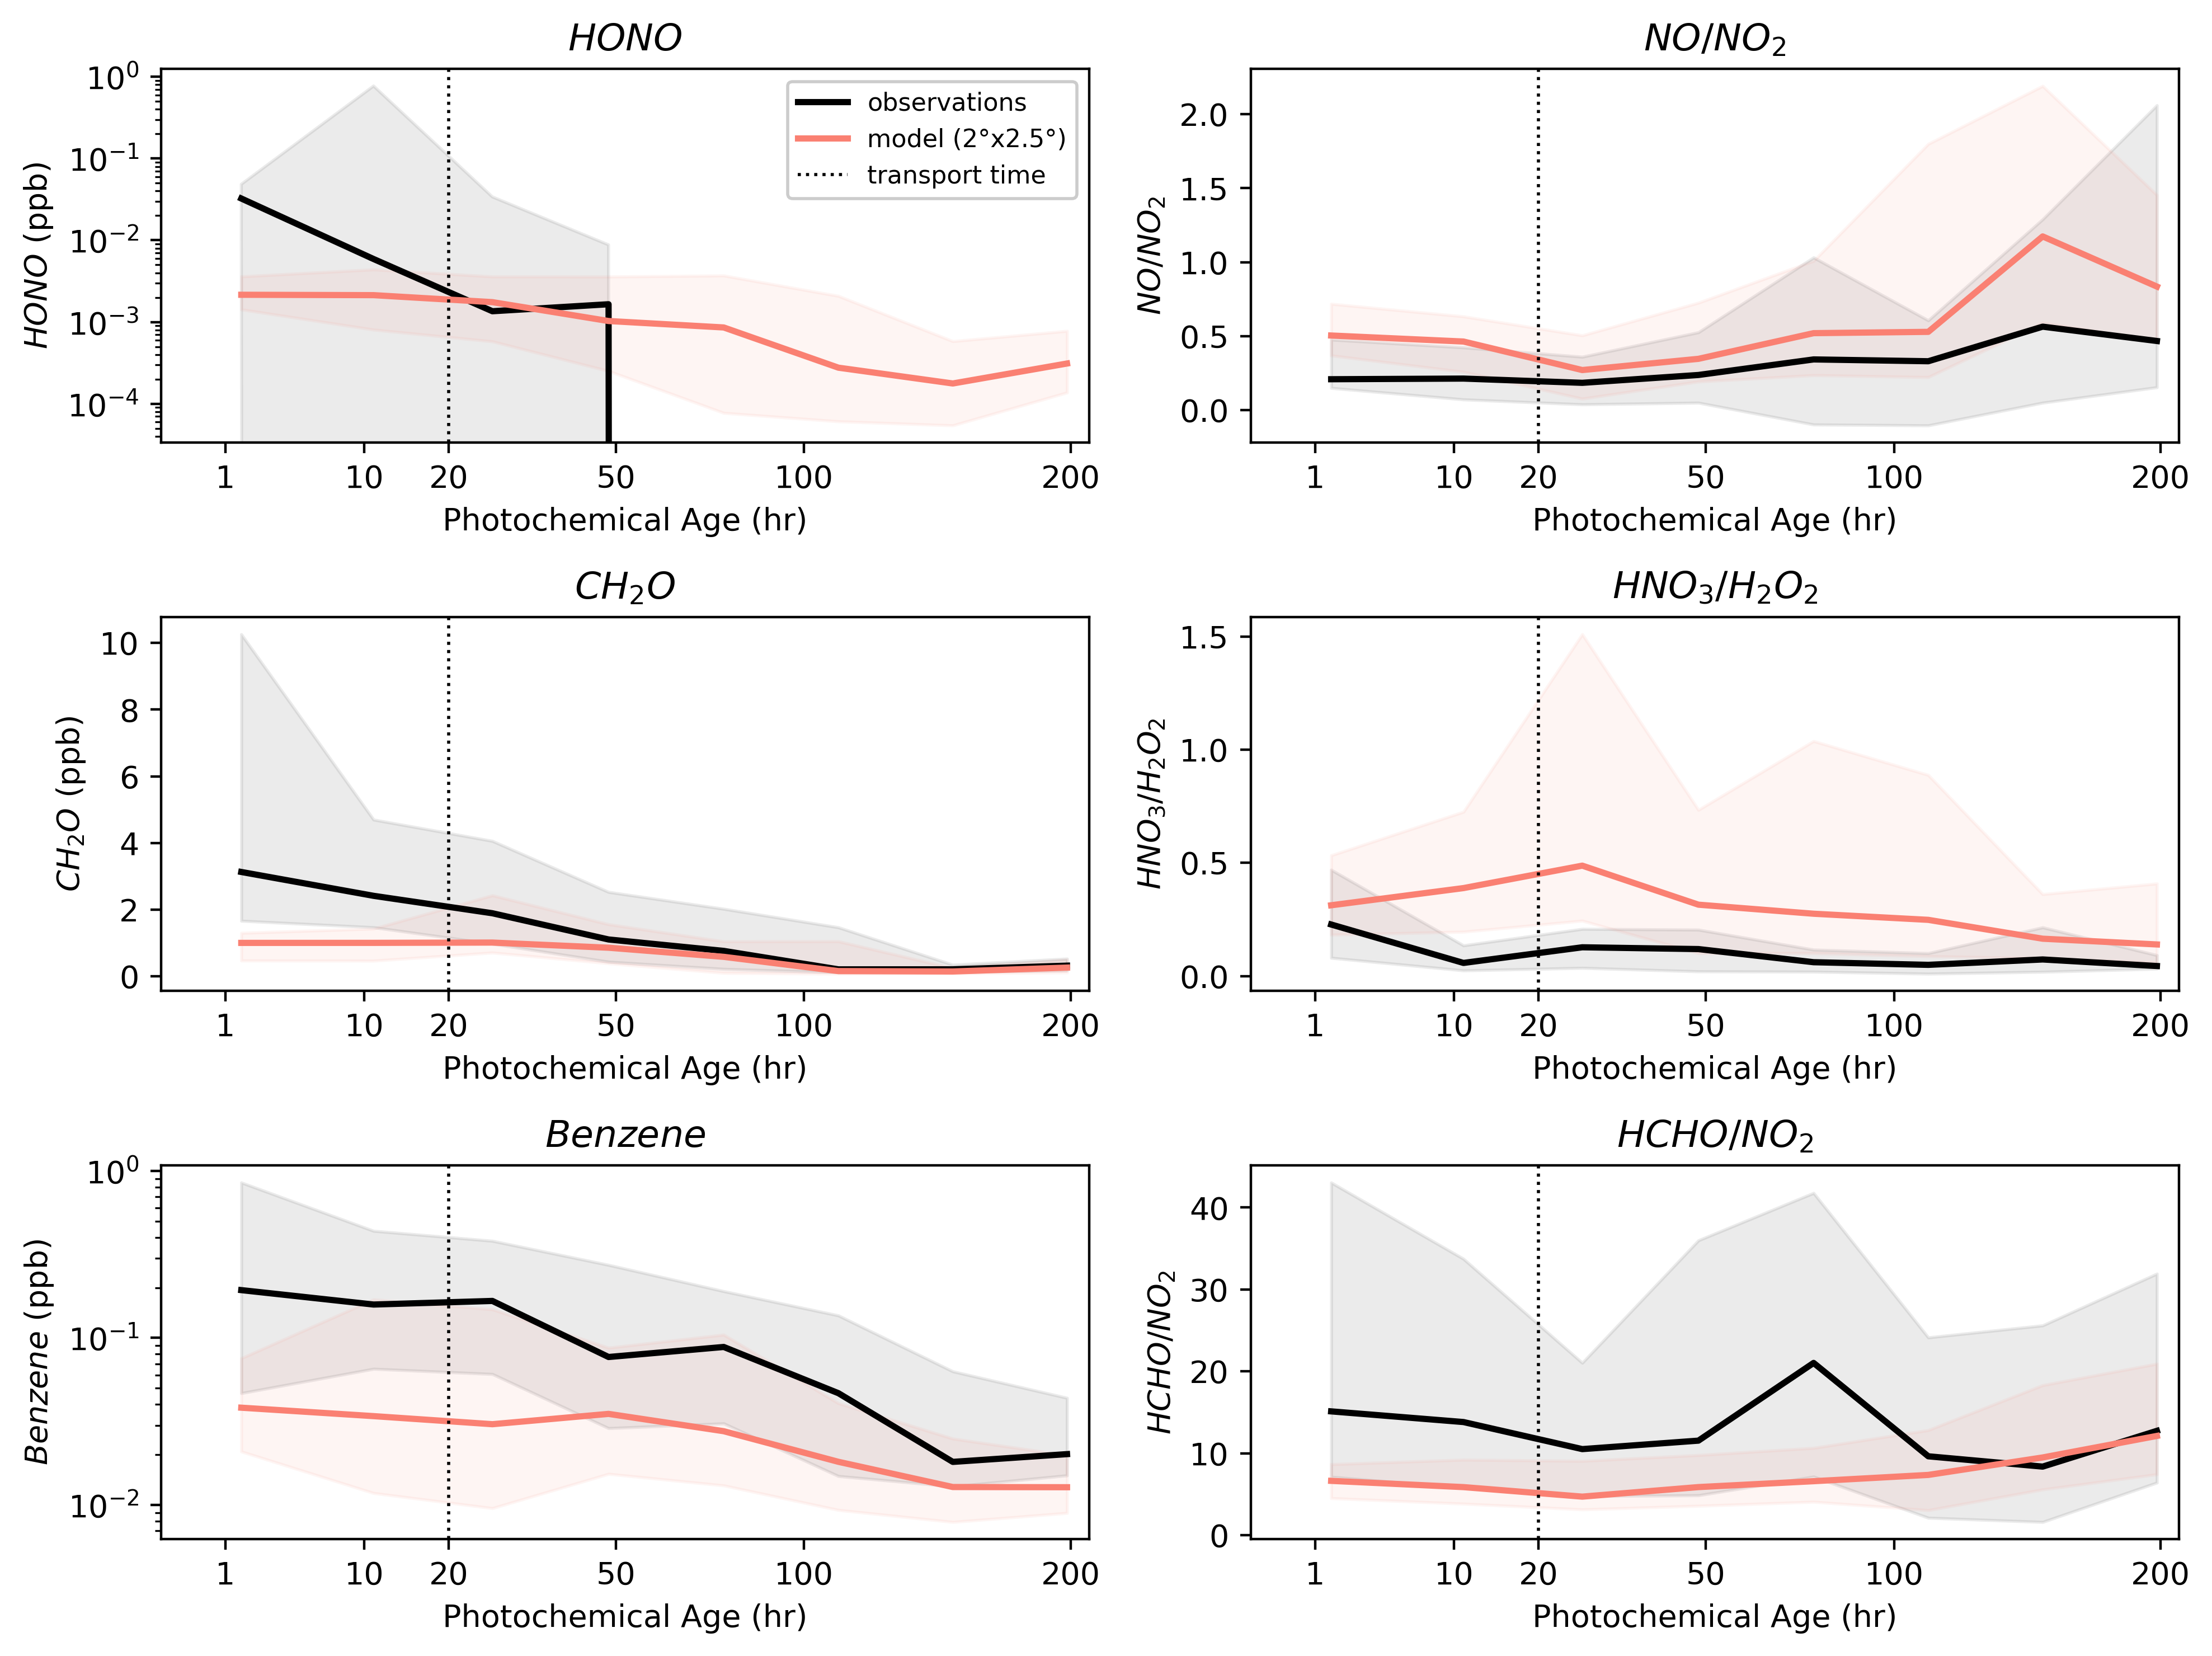

In [17]:
fig, axs = plt.subplots(3, 2, figsize=(10,7.5), dpi=400)

# Flatten axs for easier iteration
axs = axs.flatten()

# Define the variables to plot
variables = [
    {'col': 'HNO2', 'model_col': 'HNO2_model', 'title': '$HONO$', 'ylabel': '$HONO$ (ppb)'},
    {'col': 'NO/NO2', 'model_col': 'NO/NO2_model', 'title': '$NO/NO_2$', 'ylabel': '$NO/NO_2$'},
    {'col': 'CH2O', 'model_col': 'CH2O_model', 'title': '$CH_2O$', 'ylabel': '$CH_2O$ (ppb)'},
    {'col': 'HNO3/H2O2', 'model_col': 'HNO3/H2O2_model', 'title': '$HNO_3/H_2O_2$', 'ylabel': '$HNO_3/H_2O_2$'},
    {'col': 'Benzene', 'model_col': 'BENZ_model', 'title': '$Benzene$', 'ylabel': '$Benzene$ (ppb)'},
    {'col': 'CH2O/NO2', 'model_col': 'CH2O/NO2_model', 'title': '$HCHO/NO_2$', 'ylabel': '$HCHO/NO_2$'},
    ]

for idx, var in enumerate(variables):
    col = var['col']
    model_col = var['model_col']
    nested_model_col = var['model_col'].replace('model', 'nested_model')
    
    model_colors = {model_col: 'salmon', col:'k', nested_model_col:'red'}
    
    tmp = merged_df.copy(deep=True)
    # Don't scale the ratios
    if col != 'NO/NO2' and col != 'HNO3/H2O2' and col != 'CH2O/NO2':  # Don't scale O3/CO ratio
        tmp[model_col] = tmp[model_col]*1e9
        # tmp[nested_model_col] = tmp[nested_model_col]*1e9
        tmp[col] = tmp[col]*1e-3
    
    # observations
    bin_result = binned_statistic(tmp['age'].values, tmp[col].values, statistic=lambda y:np.nanmedian(y), bins=sqrt_bins)
    tenth_result = binned_statistic(tmp['age'].values, tmp[col].values, statistic=lambda y:np.nanpercentile(y,16), bins=sqrt_bins)
    ninetieth_result = binned_statistic(tmp['age'].values, tmp[col].values, statistic=lambda y:np.nanpercentile(y,84), bins=sqrt_bins)
    bin_centers = bin_result.bin_edges[1:] - (abs(bin_result.bin_edges[0]-bin_result.bin_edges[1]))/2
    
    axs[idx].plot(bin_centers, bin_result.statistic, label='observations', color=model_colors[col], linewidth=2)
    axs[idx].fill_between(bin_centers, tenth_result.statistic, ninetieth_result.statistic, alpha=0.08, color=model_colors[col])
    
    # model
    bin_result = binned_statistic(tmp['age'].values, tmp[model_col].values, statistic=lambda y:np.median(y), bins=sqrt_bins)
    tenth_result = binned_statistic(tmp['age'].values, tmp[model_col].values, statistic=lambda y:np.nanpercentile(y,16), bins=sqrt_bins)
    ninetieth_result = binned_statistic(tmp['age'].values, tmp[model_col].values, statistic=lambda y:np.nanpercentile(y,84), bins=sqrt_bins)
    
    axs[idx].plot(bin_centers, bin_result.statistic, label='model (2°x2.5°)', color=model_colors[model_col], linewidth=2)
    axs[idx].fill_between(bin_centers, tenth_result.statistic, ninetieth_result.statistic, alpha=0.08, color=model_colors[model_col])
    
    axs[idx].axvline(x=20, label="transport time", color='black', linestyle=':', linewidth=1)
    
    if col == 'HNO2' or col == 'Benzene':
        axs[idx].set_yscale('log')

    # Set scales and labels
    axs[idx].set_xscale('function', functions=(np.sqrt, np.square))
    axs[idx].set_title(var['title'])
    axs[idx].set_ylabel(var['ylabel'], fontsize=10)
    axs[idx].set_xlabel('Photochemical Age (hr)', fontsize=10)
    
    axs[idx].set_xticks([1, 10, 20, 50, 100, 200])
    axs[idx].set_xticklabels([1, 10, 20, 50, 100, 200])
    axs[idx].set_xlim(left=0)
    
    if idx == 0:  # Only show legend for first panel
        axs[idx].legend(fontsize=8, framealpha=1)

# Adjust layout to prevent overlapping
plt.tight_layout()

#save figure as pdf
plt.savefig("../../figures/supfig_13.pdf", bbox_inches='tight', dpi=300)